# Derived from https://tensorflow.keras.io/examples/imdb_cnn/

In [31]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [32]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.2.0-rc3
Version 2, minor 2


In [0]:


from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.datasets import imdb

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython
import numpy as np

# Parameters:
- max_features: number of words in the vocabulary (and hence, the length of the One Hot Encoding feature vector)
- maxlen: number of words in a review
- embedding_dims: length of word vector
- filters: number of convolutional kernels.  These are "features" created by convolution.

In [0]:
# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 8

special = { "<PAD>": 0, 
           "<START>": 1,
           "<UNK>": 2
           }

In [35]:
print('Loading data...')
# start_char == 1: start of sequence character is encoded with integer 1
# oov_char   == 2: Out of Vocabulary word is encoded with integer 2
# index_from == 3: The first word (i.e, most frequent) in the vocabulary is encoded with integer 3
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features,
                                                      start_char=special["<START>"],
                                                      oov_char=special["<UNK>"],
                                                      index_from=3
                                                      )
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)



Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


# Examine the text data

In [36]:

# See https://stackoverflow.com/questions/42821330/restore-original-text-from-keras-s-imdb-dataset
# word_index: maps words to rank in vocabulary (0 is most frequent)
word_index = imdb.get_word_index()

# Create word to index map
# load_data has assigned indexes 0, 1, 2 to (<PAD>, <START>, <UNK>) so load_data assigns the rank 0 word to index 3
word_index = { w:(k+3) for w,k in word_index.items() }

# Add the special characters to the word to index map
for word, idx in special.items():
  word_index[word] = idx

# Reverse map: index to word
# Index_word: map index to word
index_word = { idx:w for (w, idx) in word_index.items() }

sentiment = { 0: "negative", 1: "positive"}

# Print row header
print("i\tSentiment\treview")
print("-\t---------\t------")

# Examine the first few training examples
# An example is a sequence (of length exactly maxline (because we have added padding)
# - Sequence of integers
# - Where integer i represents word index_word[i]
for i, rev in enumerate(x_train[0:5]):
  # Map each index in the example back to word
  rev_words = [ index_word[idx] for idx in rev if idx != 0]

  # Sentiment sent is the target value
  sent = y_train[i]
  print("{i:d}:\t({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )

i	Sentiment	review
-	---------	------
0:	(positive)	<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly <UNK> was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little <UNK> that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big <UNK> for the whole film but these ch

# Utility functions

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

def plot_training(history):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number
  
  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """  
  
  # Accuracy
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  
  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [0]:


def createModel(doConv=True, learn_embeddings=True):
  """
  Create a Sequential model

  Parameters
  -----------
  doConv: Boolean.  If True, create features using Convolutional Layer
  learn_embeddings: Boolean.  If True, learn embeddings; else just use OHE as embedding

  Returns
  --------
  model: Sequential model

  - First layer is an Embedding Layer
  -  if learn_embedding is True: the model will "learn" the best embedding
  -  if learn_embedding is False: the embedding will just be the OHE
  """
  model = Sequential()

  # we start off with an efficient embedding layer which maps
  # our vocab indices into embedding_dims dimensions
  if learn_embeddings:
    # Word embeddings are trainable and small size (embedding_dims) vectors
    # Embedding layer maps 
    # - elements of sequence (OHE vectors of length max_features)
    # - to a vector of length embedding_dims
    # - where maxlen is the maximum length of a sequence
    model.add(Embedding(max_features,
                      embedding_dims,
                      input_length=maxlen))
  else:
    # "Embeddings" are simply One Hot Encoding of the vocabulary
    # - word embeddings are NOT trainable and LARGE size (length of vocabulary) vectors
    # NOTE: this is NOT the best way to perform OHE ! Super slow !
    #   We do this just to show that OHE is a simple type of embedding
    weights_OHE= createOHE()
    embedding_dims_OHE = weights_OHE.shape[-1]

    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
    model.add(Embedding(max_features,
                      embedding_dims_OHE,
                      input_length=maxlen,
                      weights=[weights_OHE],
                      trainable=False
                     )
         )
    
  model.add(Dropout(0.2))

  if doConv:
    # we add a Convolution1D, which will learn features from "kernel_size" consecutive tokens
    model.add(Conv1D(filters,
                    kernel_size,
                    padding='valid',
                    activation='relu',
                    strides=1))
    
  # we use Global Max Pooling to eliminate the time dimensions
  # - Turns variable length sequence to fixed length
  model.add(GlobalMaxPooling1D())

  # We add a vanilla hidden layer to create new features from the fixed length encoding
  model.add(Dense(hidden_dims))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))

  # Add Binary Classifier as final layer
  # We project onto a single unit output layer, and squash it with a sigmoid:
  model.add(Dense(1))
  model.add(Activation('sigmoid'))

  return model

def trainModel(model):
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['acc']
                )
  
  es_callback = EarlyStopping(monitor='val_loss', min_delta=.005, patience=2, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

  callbacks = [ es_callback,
                # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
                ] 

  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_test, y_test),
            callbacks=callbacks)
  
  return history

def createOHE():
  mat = np.diag( np.ones(max_features))
  return mat



# Simple model
- OHE
- GlobalMaxPooling1D to convert from variable length to fixed length

Summary
- Input: Sequence (length maxlen) of words represented as integer
- Converted to sequence (length maxlen)of OHE vectors (each of length max_features)
- Pooled over sequence length dimension to give fixed length vector (length max_features)
- FC layer + Binary Classifier

Notes
- The number of parameters in the "embedding layer" (really OHE)
- Is mapping of Vocab size (max_features=5000) tokens to OHE vector of length Vocab size(max_features=5000(
  - BIG !



In [39]:
model_ohe = createModel(learn_embeddings=False, doConv=False)
model_ohe.summary()



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 400, 5000)         25000000  
_________________________________________________________________
dropout_6 (Dropout)          (None, 400, 5000)         0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 5000)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 250)               1250250   
_________________________________________________________________
dropout_7 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_6 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

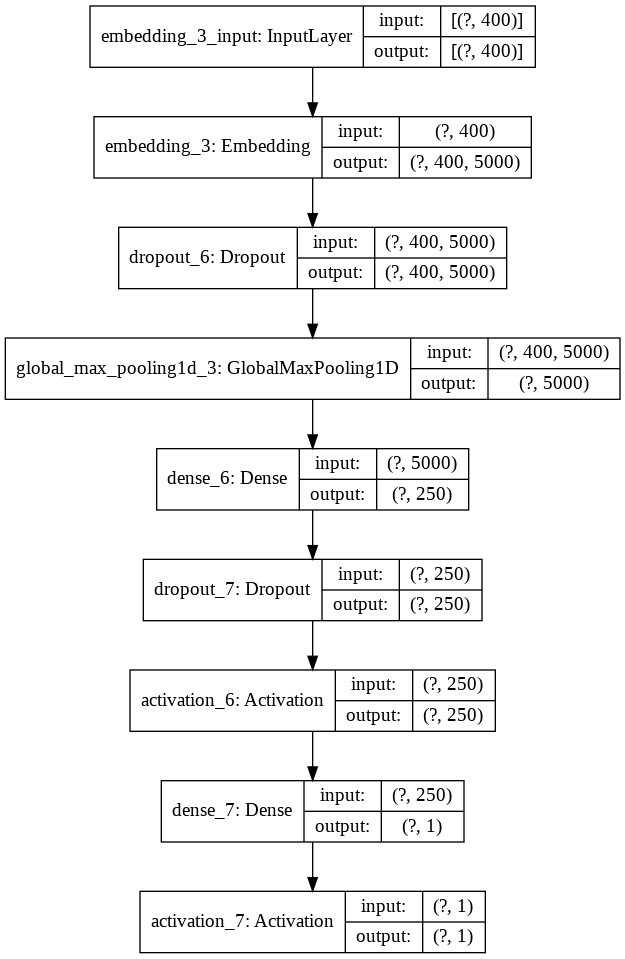

In [40]:
plotFile = plotModel(model_ohe, "imbdb_OHE_noconv")
IPython.display.Image(plotFile) 

In [41]:
history_ohe = trainModel(model_ohe)

Epoch 1/8
782/782 [==============================] - 114s 146ms/step - loss: 0.3532 - acc: 0.8462 - val_loss: 0.2890 - val_acc: 0.8763
Epoch 2/8
782/782 [==============================] - 114s 146ms/step - loss: 0.2470 - acc: 0.8941 - val_loss: 0.2924 - val_acc: 0.8752
Epoch 3/8
782/782 [==============================] - 114s 145ms/step - loss: 0.1925 - acc: 0.9224 - val_loss: 0.3014 - val_acc: 0.8753


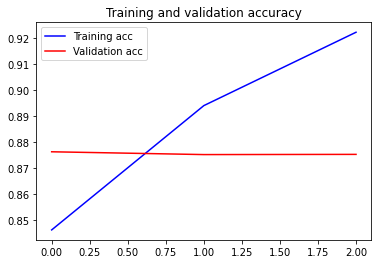

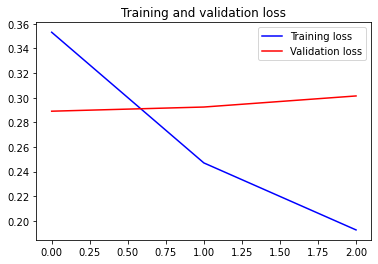

In [42]:
plot_training(history_ohe)

## Note: the test data set was used as the validation_data in the fit method above
- so nothing really to see here


In [43]:
score, acc = model_ohe.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 54s 69ms/step - loss: 0.2890 - acc: 0.8763
Test score: 0.2890195846557617
Test accuracy: 0.8762800097465515


In [44]:
print("OHE Embeddings (first few):")
embeddings_ohe = model_ohe.layers[0].get_weights()[0]
embeddings_ohe[:4,:7]

OHE Embeddings (first few):


array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

# Model with learned embeddings
- learn low-dimensional word embeddings

Summary
- same as "simple" model, but use word vectors rather than OHE

Notes
- The number of parameters in the embedding layer (learned embedding)
- Is mapping of Vocab size (max_features=5000) tokens to  vector of length embedding_dims=50 (versus Vocab size(max_features=5000 for OHE)
  - Smaller by factor of 100 !
- The Dense layer that follows also has fewer parameters
  - Factor of 100 (plus biases) because inputs are smaller by a factor of 100





In [45]:
model_emb = createModel(doConv=False)
model_emb.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 400, 50)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 250)               12750     
_________________________________________________________________
dropout_9 (Dropout)          (None, 250)               0         
_________________________________________________________________
activation_8 (Activation)    (None, 250)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

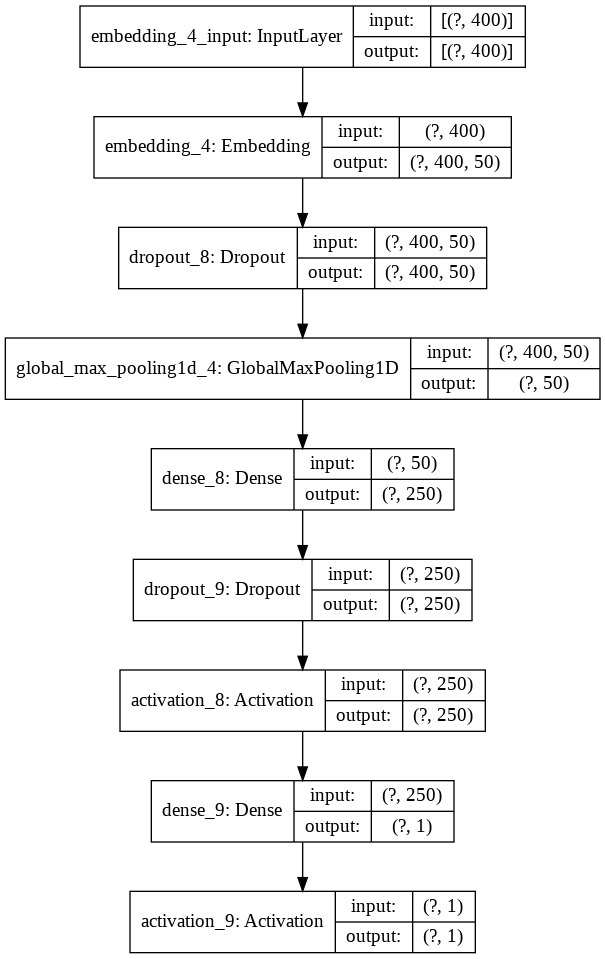

In [46]:
plotFile = plotModel(model_emb, "imbdb_emb")
IPython.display.Image(plotFile) 

In [47]:
history_emb=trainModel(model_emb)

Epoch 1/8
782/782 [==============================] - 7s 9ms/step - loss: 0.4381 - acc: 0.7853 - val_loss: 0.3174 - val_acc: 0.8638
Epoch 2/8
782/782 [==============================] - 7s 9ms/step - loss: 0.2824 - acc: 0.8816 - val_loss: 0.3003 - val_acc: 0.8730
Epoch 3/8
782/782 [==============================] - 7s 9ms/step - loss: 0.2449 - acc: 0.8999 - val_loss: 0.3105 - val_acc: 0.8656
Epoch 4/8
782/782 [==============================] - 7s 9ms/step - loss: 0.2210 - acc: 0.9117 - val_loss: 0.3072 - val_acc: 0.8694


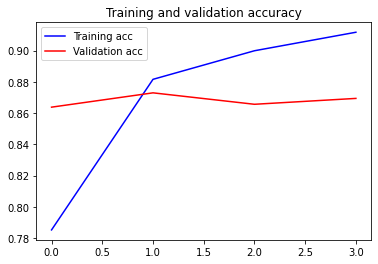

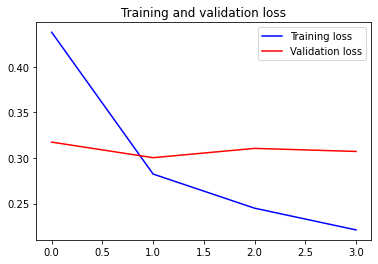

In [48]:
plot_training(history_emb)

In [49]:
score, acc = model_emb.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 2s 2ms/step - loss: 0.3003 - acc: 0.8730
Test score: 0.30032089352607727
Test accuracy: 0.8729599714279175


# Model with learned embeddings, n-grams (phrases)
- conv1d to learn n-grams

Summary
- After converting words to word vectors: use multiple kernels to find 3-grams 


In [50]:
model_emb_ngram = createModel(doConv=True)
model_emb_ngram.summary()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 50)           250000    
_________________________________________________________________
dropout_10 (Dropout)         (None, 400, 50)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 398, 250)          37750     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 250)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 250)               62750     
_________________________________________________________________
dropout_11 (Dropout)         (None, 250)               0         
_________________________________________________________________
activation_10 (Activation)   (None, 250)              

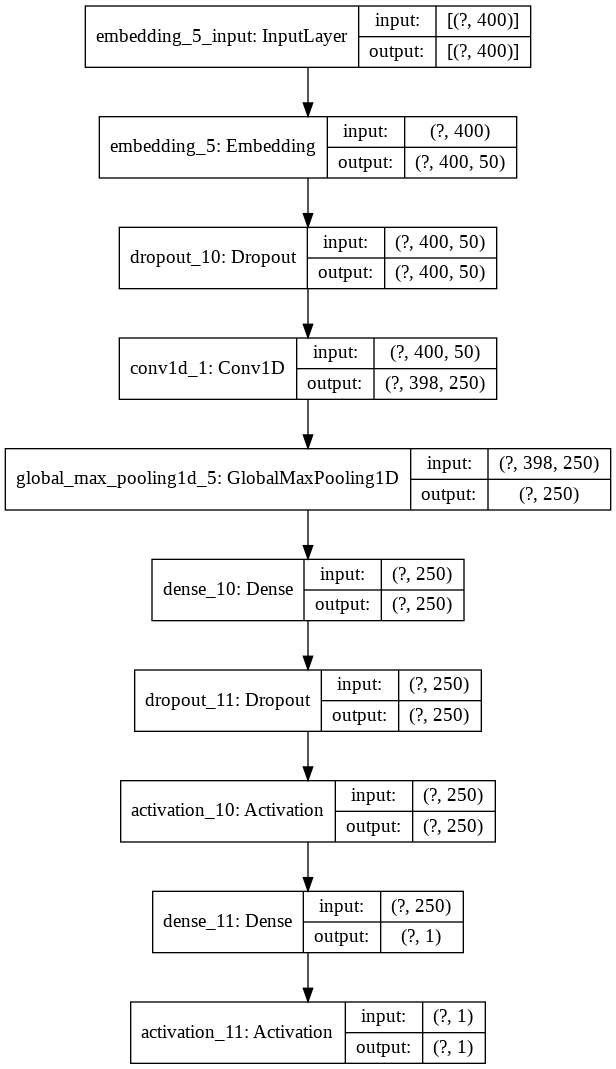

In [51]:
plotFile = plotModel(model_emb_ngram, "imbdb_emb_ngram")
IPython.display.Image(plotFile) 

In [52]:
history_emb_ngram=trainModel(model_emb_ngram)

Epoch 1/8
782/782 [==============================] - 9s 12ms/step - loss: 0.4100 - acc: 0.7977 - val_loss: 0.2861 - val_acc: 0.8769
Epoch 2/8
782/782 [==============================] - 9s 11ms/step - loss: 0.2305 - acc: 0.9073 - val_loss: 0.2547 - val_acc: 0.8967
Epoch 3/8
782/782 [==============================] - 9s 11ms/step - loss: 0.1628 - acc: 0.9401 - val_loss: 0.2910 - val_acc: 0.8829
Epoch 4/8
782/782 [==============================] - 9s 12ms/step - loss: 0.1153 - acc: 0.9572 - val_loss: 0.3461 - val_acc: 0.8666


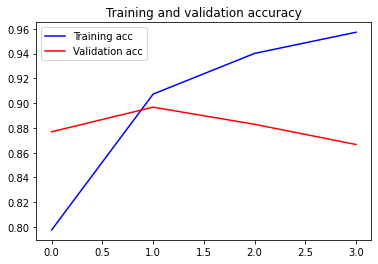

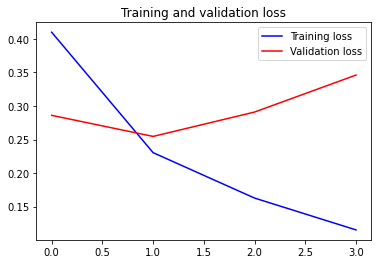

In [53]:
plot_training(history_emb_ngram)

In [54]:
score, acc = model_emb_ngram.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

782/782 [==============================] - 2s 3ms/step - loss: 0.2547 - acc: 0.8967
Test score: 0.2546856701374054
Test accuracy: 0.8967199921607971
